<a href="https://colab.research.google.com/github/aahFancyGun/dataScienceClass/blob/master/unit2/YangChauU2Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction#

The following model was designed to represent the chance that in a given year thirty percent of the the American population or more will be considered normal weight. The data was sourced from the CDC and the data points used are representations of the averages across all sexes from ages 20 and up for a given range of years. Many assumptions made during this project were informed by America's status as one of the most obese countries in the world.


In [2]:
!pip install "preliz[full,notebook]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 15.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [3]:
import pandas as pd
import numpy as np
import preliz as pz
import arviz as az
import pymc as pm


In [4]:
url = 'https://github.com/aahFancyGun/dataScienceClass/blob/master/table026.xlsx'

obesity = pd.read_csv('obesityData.csv')
obesity

FileNotFoundError: [Errno 2] No such file or directory: 'obesityData.csv'

#Prior#
Based off the knowledge that America is one of the most obese countries in the world I am assuming that over the years 1988 to 2014 forty percent of the time thirty percent or more of the population will be considered normal weight while sixty percent of the time less than 30 percent will be considered underweight.

In [1]:
pz.Beta(alpha = 2, beta = 3).plot_pdf()


NameError: name 'pz' is not defined

In [31]:
normalWeightDataQuery = obesity.query('PANEL == "Normal weight (BMI from 18.5 to 24.9)" and STUB_LABEL == "20 years and over" and UNIT == "Percent of population, age-adjusted"')
normalWeightDataQuery

normalWeight = normalWeightDataQuery[["ESTIMATE"]]

normalWeight

,ESTIMATE
0,41.6
1,33.0
2,32.3
3,31.6
4,30.8
5,29.8
6,29.6
7,28.9
8,27.7
9,26.0


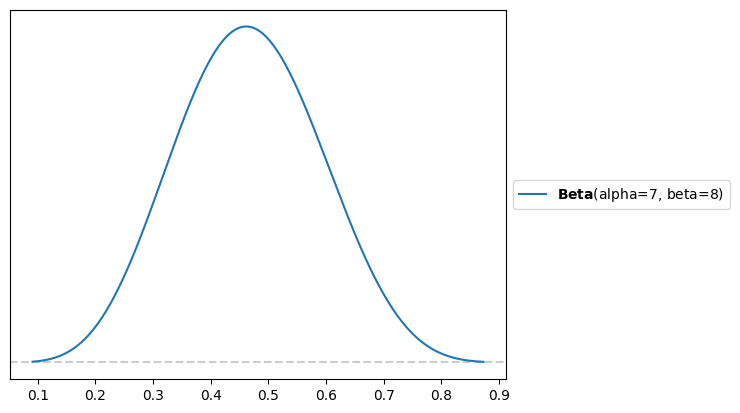

In [60]:
posterior = pz.Beta(alpha = 2 + 5, beta = 3+5).plot_pdf()


In [61]:
normWeights = np.repeat(0,5)
obeseWeights = np.repeat(0,5)

weights = np.concatenate( [normWeights,obeseWeights] )

with pm.Model() as wmby_FT_model:

  θ = pm.Beta('θ' , alpha = 2. , beta = 3.)
  y = pm.Bernoulli('y', p = θ, observed = weights)
  idata_Obesity = pm.sample(1000)

<Axes: title={'center': 'θ'}>

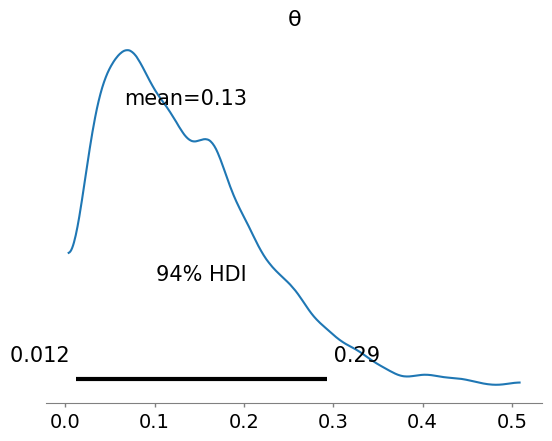

In [62]:
az.plot_posterior(idata_Obesity)

#PYMC graph analysis#

 In my prior I predicted that the percentage would be 40 percent of the time 30 percent or more people would be consisdered normal weight but the posterior was in actuality less than half of that, showing how severe the obesity epidemic has become. Based on this graph the likelihood that a given year will have a population wherein thirty percent of the population is considered normal weight will be thirteen percent. This does not surprise me as America has been suffering from an obesity epidemic for years and the data itself has showed that the number of people considered overweight only continues to grow. The consumerist nature of the average American in tandem with the ease of access to unhealthy foods and lack of regulations on what can be consumed is likely to be blamed for this graph.